In [1]:
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import numpy as np
import os

np.seterr(all="ignore")


from threeML import *
from threeML.utils.data_builders import TimeSeriesBuilder
silence_warnings()
%matplotlib inline
set_threeML_style()

14:11:56 WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=699386;file:///home/polpy/astromodels/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=842499;file:///home/polpy/astromodels/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=150959;file:///home/polpy/astromodels/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=943621;file:///home/polpy/astromodels/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=318562;file:///home/polpy/astromodels/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=513261;file:///home/polpy/astromodels/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=421167;file:///home/polpy/astromodels/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=462918;file:///home/polpy/astromodels/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=394659;file:///home/polpy/astromodels/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=252968;file:///home/polpy/astromodels/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=858204;file:///home/polpy/astromodels/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=75263;file:///home/polpy/astromodels/astromodels/core/parameter.py#704\704]8;;\

14:11:56 INFO      Starting 3ML!                                                                     ]8;id=39535;file:///home/polpy/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=900216;file:///home/polpy/threeML/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=134713;file:///home/polpy/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=402399;file:///home/polpy/threeML/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=131602;file:///home/polpy/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=210795;file:///home/polpy/threeML/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=626585;file:///home/polpy/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=450138;file:///home/polpy/threeML/threeML/__init__.py#40\40]8;;\

         WARNING   no display variable set. using backend for graphics without display (agg)         ]8;id=284720;file:///home/polpy/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=616124;file:///home/polpy/threeML/threeML/__init__.py#46\46]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=202644;file:///home/polpy/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=621784;file:///home/polpy/threeML/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=128508;file:///home/polpy/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=546735;file:///home/polpy/threeML/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=381482;file:///home/polpy/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=478162;file:///home/polpy/threeML/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=815697;file:///home/polpy/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=209948;file:///home/polpy/threeML/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=667755;file:///home/polpy/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=595622;file:///home/polpy/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=200004;file:///home/polpy/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=310847;file:///home/polpy/threeML/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=378614;file:///home/polpy/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=667979;file:///home/polpy/threeML/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=96572;file:///home/polpy/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=603080;file:///home/polpy/threeML/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

In [11]:
# reading polarization data from AstroSat CZTI and creating polarization plugin
trigger_time = 296907549.24

czti_polarization_ts = TimeSeriesBuilder.from_pol_polarization(name='czti_pol', polevents='/home/polpy/polpy_test/polpy/examples/cztipol_GRB190530A.pevt',specrsp =None,
                                              polrsp='/home/polpy/polpy_test/polpy/examples/CZTI_POLRSP_EMIN_110_EMAX_1000.prsp',
                                               trigger_time=trigger_time)

czti_polarization_ts.set_background_interval("-350.--150.","150.-350.")
czti_polarization_ts.set_active_time_interval('0-26.9')
czti_data = czti_polarization_ts.to_polarizationlike()

UnboundLocalError: local variable 'ebounds' referenced before assignment

In [3]:
#effective area correction
#czti_data.fix_effective_area_correction(2.0)
czti_data.use_effective_area_correction(0.1,300.0)

Using effective area correction


In [4]:
# reading spectrum data from Fermi GBM and creating spectrum plugin
gbm_cat = FermiGBMBurstCatalog()
gbm_cat.query_sources('GRB190530430')
grb_info = gbm_cat.get_detector_information()["GRB190530430"]
gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]

         INFO      Building cache for fermigbrst                                 ]8;id=299332;file:///home/localization/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=899544;file:///home/localization/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

In [5]:
print(source_interval,"\n", background_interval, "\n", gbm_detectors, "\n", type(gbm_detectors))

1.792000-20.224000 
 -10.000000--1.830000,40.500000-50.830000 
 [] 
 <class 'numpy.ndarray'>


In [6]:
gbm_detectors = ['n0', 'n1', 'n2', 'b0'] #can add 'n3', 'n5'

In [7]:
dload = download_GBM_trigger_data("GRB190530430", detectors=gbm_detectors)

16:11:44 INFO      file glg_cspec_n0_bn190530430_v00.pha is already downloaded!           ]8;id=170181;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=89655;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

16:11:45 INFO      file glg_cspec_n0_bn190530430_v02.rsp2 is already downloaded!          ]8;id=309098;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=727249;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

16:11:46 INFO      file glg_tte_n0_bn190530430_v00.fit is already downloaded!             ]8;id=524782;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=795780;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

16:11:47 INFO      file glg_cspec_n1_bn190530430_v00.pha is already downloaded!           ]8;id=746247;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=989963;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

16:11:48 INFO      file glg_cspec_n1_bn190530430_v02.rsp2 is already downloaded!          ]8;id=540268;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=292219;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

16:11:49 INFO      file glg_tte_n1_bn190530430_v00.fit is already downloaded!             ]8;id=952353;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=653210;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

16:11:50 INFO      file glg_cspec_n2_bn190530430_v00.pha is already downloaded!           ]8;id=461977;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=814201;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n2_bn190530430_v02.rsp2 is already downloaded!          ]8;id=821229;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=877532;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

16:11:51 INFO      file glg_tte_n2_bn190530430_v00.fit is already downloaded!             ]8;id=191860;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=950633;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

16:11:52 INFO      file glg_cspec_b0_bn190530430_v00.pha is already downloaded!           ]8;id=121612;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=440879;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

16:11:53 INFO      file glg_cspec_b0_bn190530430_v02.rsp2 is already downloaded!          ]8;id=726402;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=761551;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

16:11:54 INFO      file glg_tte_b0_bn190530430_v00.fit is already downloaded!             ]8;id=112718;file:///home/localization/threeML/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=298600;file:///home/localization/threeML/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|          | 0/2156 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

16:11:55 INFO      Auto-determined polynomial order: 1                                ]8;id=559456;file:///home/localization/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=798573;file:///home/localization/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

16:11:58 INFO      None 1-order polynomial fit with the mle method                               ]8;id=156893;file:///home/localization/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=273991;file:///home/localization/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=81759;file:///home/localization/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=380455;file:///home/localization/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=890032;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=470158;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

16:11:59 INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=600385;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=124660;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-20.224 for n0                                   ]8;id=291564;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=837109;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=712306;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=600523;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=849815;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=905384;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=271916;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=723799;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 4-123                                    ]8;id=520274;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=869768;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

16:12:00 INFO      Now using 120 bins                                                          ]8;id=42945;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=265155;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/2156 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

16:12:01 INFO      Auto-determined polynomial order: 1                                ]8;id=545761;file:///home/localization/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=388207;file:///home/localization/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_01 background:   0%|          | 0/128 [00:00<?, ?it/s]

16:12:04 INFO      None 1-order polynomial fit with the mle method                               ]8;id=388833;file:///home/localization/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=692095;file:///home/localization/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=605706;file:///home/localization/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=330475;file:///home/localization/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=331780;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=304834;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=777698;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=455048;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-20.224 for n1                                   ]8;id=140340;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=999913;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

16:12:05 INFO      Auto-probed noise models:                                                    ]8;id=251678;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=457639;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=536557;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=870400;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=980270;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=771473;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=49780;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=216051;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=304575;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=772037;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/2156 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

         INFO      Auto-determined polynomial order: 1                                ]8;id=420745;file:///home/localization/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=804102;file:///home/localization/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_02 background:   0%|          | 0/128 [00:00<?, ?it/s]

16:12:09 INFO      None 1-order polynomial fit with the mle method                               ]8;id=985503;file:///home/localization/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=55525;file:///home/localization/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n2_bkg.h5                                         ]8;id=480457;file:///home/localization/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=771448;file:///home/localization/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n2_bkg.h5                                         ]8;id=310772;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=661030;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n2_bkg.h5                              ]8;id=895897;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=890450;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-20.224 for n2                                   ]8;id=14925;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=399569;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=131068;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=831415;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=956476;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=654423;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=411687;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=980722;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 4-124                                    ]8;id=264933;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=634536;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 121 bins                                                          ]8;id=550220;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=478203;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/2156 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

16:12:10 INFO      Auto-determined polynomial order: 0                                ]8;id=975805;file:///home/localization/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=468598;file:///home/localization/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

16:12:13 INFO      None 0-order polynomial fit with the mle method                               ]8;id=805739;file:///home/localization/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=650741;file:///home/localization/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=449979;file:///home/localization/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=644497;file:///home/localization/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=746718;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=82025;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=161097;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=50545;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-20.224 for b0                                   ]8;id=661109;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=302683;file:///home/localization/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=336557;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=711822;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=510304;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=697936;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=224358;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=762902;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=484126;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=859636;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=101312;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=281114;file:///home/localization/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

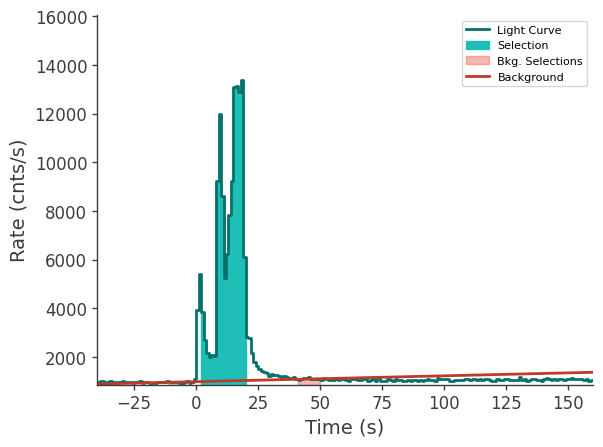

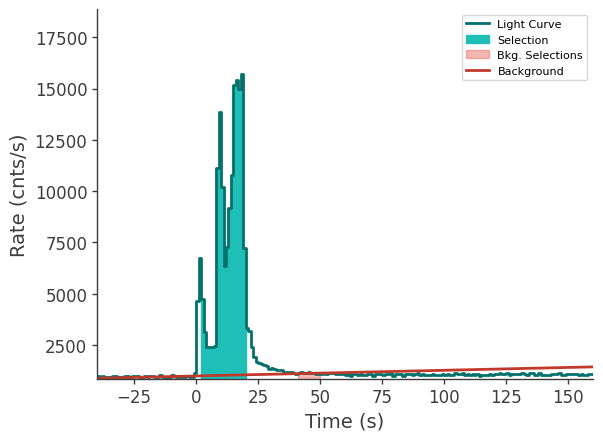

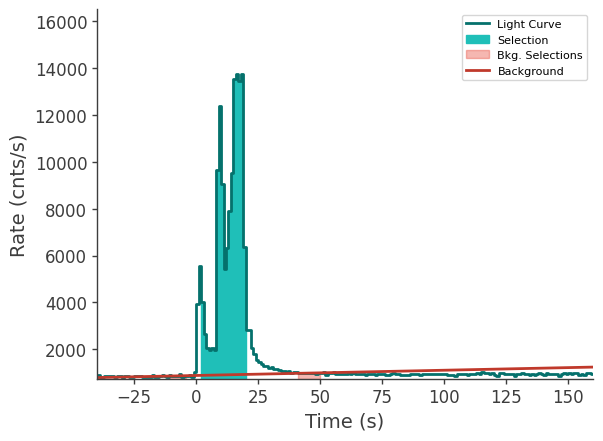

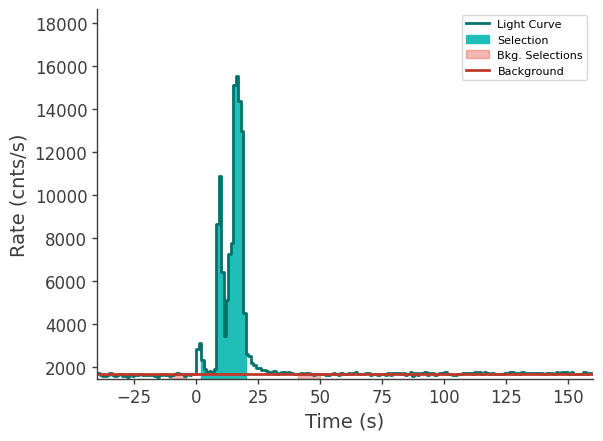

In [8]:
fluence_plugins = []
time_series = {}
#print(best_fit_model, "\n", source_interval, "\n", model.display())
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"])

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 160)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

In [9]:
#setting up spectrum model
band = Band()

band.xp.prior = Log_normal(mu=np.log(147),sigma=np.log(100))
band.xp.bounds = (None, None)

band.K.bounds = (1E-10, None)
band.K.prior = Log_uniform_prior(lower_bound=1E-5, upper_bound=1E2)

band.alpha.bounds = (-1.5, 1.0)
band.alpha.prior = Truncated_gaussian(mu=-0.29, sigma=0.5, lower_bound=-1.5, upper_bound=1.0)

band.beta.bounds = (None, -1.5)
band.beta.prior = Truncated_gaussian(mu=-2.8,sigma=0.6, lower_bound=-7, upper_bound=-1.5)

#settting up polarization model
lp = LinearPolarization(60,16.91)
lp.angle.set_uninformative_prior(Uniform_prior)
lp.degree.prior = Uniform_prior(lower_bound=0.1, upper_bound=100.0)
lp.degree.value=60.
lp.angle.value=16.91

#adding both component and defining the point source
sc =SpectralComponent('synch', band, lp)
ps = PointSource('GRB190530A',0,0, components = [sc])

combined_model = Model(ps)
datalist = DataList(*fluence_plugins,czti_data)

In [10]:
# Setting up sampler and running bayes

bayes = BayesianAnalysis(combined_model,datalist)
bayes.set_sampler("multinest")
# wrapped = [0] * len(combined_model.free_parameters)
# wrapped[3] = 1
bayes.sampler.setup(n_live_points=1000)#,
                        #    resume = False,
                        #    importance_nested_sampling=False,
                        #    verbose=True,
                        #    wrapped_params=wrapped,
                        #    chain_name='chains/synch_p2')
bayes.sample()

16:12:14 INFO      sampler set to multinest                                                ]8;id=572268;file:///home/localization/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=787020;file:///home/localization/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    7
 *****************************************************


In [ ]:
bayes.results.write_to("AstroSat_CZTI_polarization_results_GRB190530A.fits", overwrite=True)
bayes.restore_median_fit()

10:23:31 INFO      fit restored to median of posterior                                          ]8;id=99912;file:///home/localization/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=207846;file:///home/localization/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

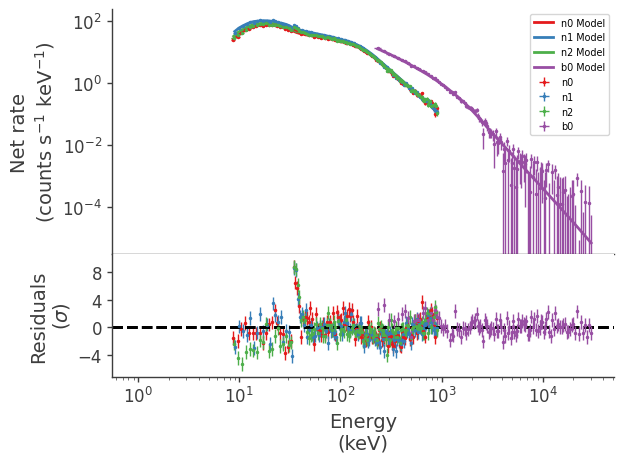

In [ ]:
fig = display_spectrum_model_counts(bayes, step=False)

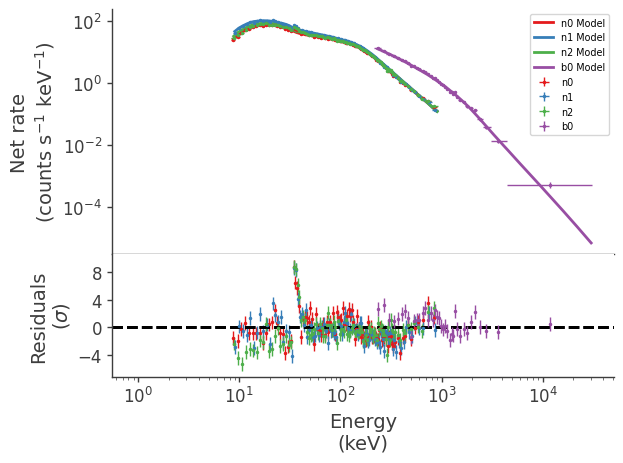

In [ ]:
fig = display_spectrum_model_counts(bayes, min_rate=20)

In [ ]:
#display everthing in bayes.results
bayes.results.display()

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
GRB190530A.spectrum.synch.Band.K,(2.004 -0.009 +0.005) x 10^-1,1 / (keV s cm2)
GRB190530A.spectrum.synch.Band.alpha,(-9.676 -0.04 +0.018) x 10^-1,
GRB190530A.spectrum.synch.Band.xp,(9.01 -0.07 +0.13) x 10^2,keV
GRB190530A.spectrum.synch.Band.beta,-3.63 -0.17 +0.14,
GRB190530A.spectrum.synch.polarization.degree,(1.9 -1.4 +1.3) x 10,
GRB190530A.spectrum.synch.polarization.angle,(0.04 +0.06 +1.6) x 10^2,deg
cons_polar_pol,(1.511 -0.023 +0.06) x 10,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0,-879.716801
n0,-1115.054532
n1,-1106.469105
n2,-1143.553401
polar_pol,-80.437427
total,-4325.231265


Values of statistical measures:

,statistical measures
AIC,8664.699316
BIC,8693.693600
DIC,8575.277275
PDIC,-0.091411
log(Z),-1868.983242


In [ ]:
cornerplot = bayes.results.corner_plot()

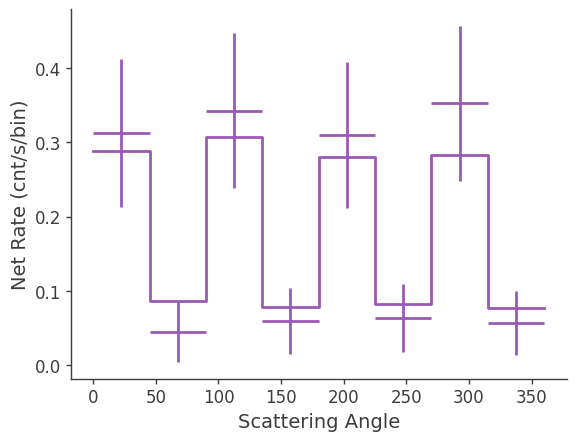

In [ ]:
modualtioncurve = czti_data.display(show_model=True)